In [1]:
# for switching between GPU and CPU
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar100

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [4]:
def show_imgs(images, columns=9, figsize=(15,7), title=''):
    """Displays images in a grid"""
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    rows = np.ceil(len(images)/columns).astype('int')
    
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        f = plt.imshow(images[i-1], cmap=plt.cm.binary)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        
    plt.show()
    
def show_random_imgs(images, title=''):
    indices = np.random.choice(range(len(images)), 45, replace=0)
    show_imgs(images[indices], title=title)

In [5]:
def filter_categories(input_set, target_set, categories):
    categories = set(categories)
    
    indices = np.apply_along_axis(
        lambda category: category[0] in categories,
        axis=-1,
        arr=target_set)
    
    recatg_map = dict(zip(categories, range(len(categories))))
    
    transformed_target_categories = np.apply_along_axis(
        lambda category: recatg_map[category[0]],
        axis=-1,
        arr=target_set[indices])
    
    return input_set[indices], transformed_target_categories

## Loading the datasets

In [6]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# normalize
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

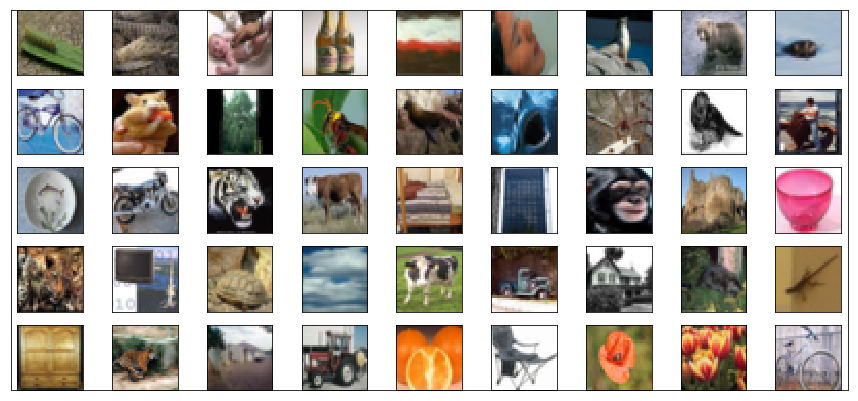

In [7]:
show_random_imgs(x_train)

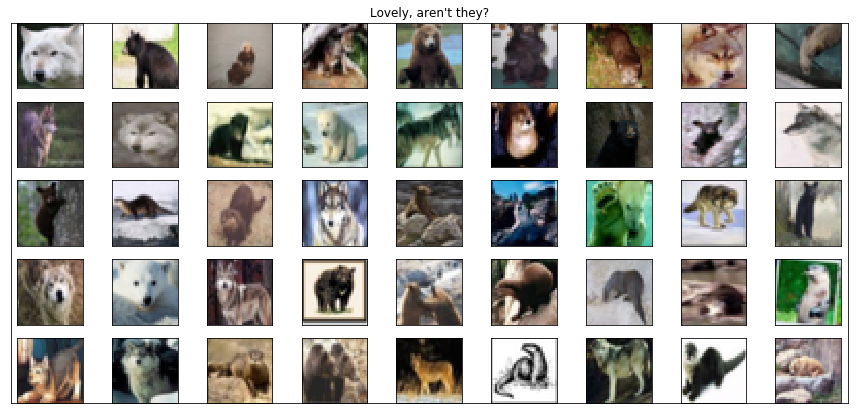

In [8]:
categories = {3,55,97} # bears, otters, wolves

xf_train, yf_train = filter_categories(x_train, y_train, categories)
xf_test, yf_test = filter_categories(x_test, y_test, categories)

# one-hot potato
yf_train = keras.utils.to_categorical(yf_train)
yf_test = keras.utils.to_categorical(yf_test)
assert yf_train.shape[1] == len(categories)

show_random_imgs(xf_train, "Lovely, aren't they?")

In [9]:
locomotive_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = locomotive_datagen.flow(
    xf_train,
    yf_train,
    batch_size=50
)

## Load the base and build a model

In [10]:
print(xf_train.shape)

(1500, 32, 32, 3)


In [11]:
from keras.applications import VGG16 as ConvBase

conv_base = ConvBase(
    include_top=False,
    weights='imagenet',
    input_shape=None)

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [12]:
for l in conv_base.layers:
    if 'pool' in l.name and ('1' in l.name or '2' in l.name):
        l.padding='same'
        l.strides=(1,1)
        
conv_base.trainable=False

In [13]:
model = build_model(
    kl.InputLayer(xf_train.shape[1:]),
    conv_base,
    kl.Flatten(),
    kl.Dropout(.3),
    kl.Dense(256, activation='relu'),
    kl.Dense(3, activation='softmax'),
    verbose=True,
    optimizer=keras.optimizers.RMSprop(lr=1e-4)
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Model summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
N

In [14]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=50,
    validation_data=(xf_test,yf_test),
    workers=4,
    use_multiprocessing=True)

Epoch 1/50
30/30 [==============================] - 7s 223ms/step - loss: 1.0986 - acc: 0.4520 - val_loss: 0.8955 - val_acc: 0.5933
Epoch 2/50
30/30 [==============================] - 5s 150ms/step - loss: 0.9835 - acc: 0.5100 - val_loss: 0.8320 - val_acc: 0.6300
Epoch 3/50
30/30 [==============================] - 5s 150ms/step - loss: 0.9033 - acc: 0.5733 - val_loss: 0.8644 - val_acc: 0.6267
Epoch 4/50
30/30 [==============================] - 5s 151ms/step - loss: 0.8722 - acc: 0.5987 - val_loss: 0.8098 - val_acc: 0.6200
Epoch 5/50
30/30 [==============================] - 5s 151ms/step - loss: 0.8483 - acc: 0.6060 - val_loss: 0.7402 - val_acc: 0.6700
Epoch 6/50
30/30 [==============================] - 5s 151ms/step - loss: 0.8210 - acc: 0.6273 - val_loss: 0.7313 - val_acc: 0.7000
Epoch 7/50
30/30 [==============================] - 5s 151ms/step - loss: 0.8325 - acc: 0.6187 - val_loss: 0.8342 - val_acc: 0.6333
Epoch 8/50
30/30 [==============================] - 5s 150ms/step - loss: 0.

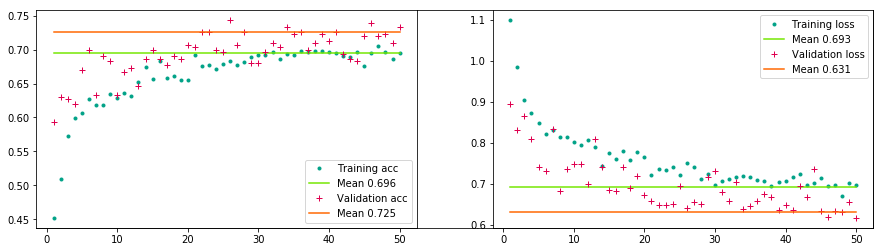

In [15]:
plot_history(hist)

In [16]:
conv_base.trainable = True
for l in conv_base.layers[:-4]: l.trainable=False

model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

In [17]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=30,
    epochs=50,
    validation_data=(xf_test,yf_test),
    workers=4,
    use_multiprocessing=True)

Epoch 1/50
30/30 [==============================] - 7s 217ms/step - loss: 0.4235 - acc: 0.7973 - val_loss: 0.3640 - val_acc: 0.8278
Epoch 2/50
30/30 [==============================] - 6s 190ms/step - loss: 0.3876 - acc: 0.8227 - val_loss: 0.3722 - val_acc: 0.8189
Epoch 3/50
30/30 [==============================] - 6s 190ms/step - loss: 0.3792 - acc: 0.8329 - val_loss: 0.3829 - val_acc: 0.8189
Epoch 4/50
30/30 [==============================] - 6s 189ms/step - loss: 0.4008 - acc: 0.8098 - val_loss: 0.3591 - val_acc: 0.8311
Epoch 5/50
30/30 [==============================] - 6s 188ms/step - loss: 0.3848 - acc: 0.8220 - val_loss: 0.3522 - val_acc: 0.8378
Epoch 6/50
30/30 [==============================] - 6s 188ms/step - loss: 0.3798 - acc: 0.8373 - val_loss: 0.3485 - val_acc: 0.8367
Epoch 7/50
30/30 [==============================] - 6s 190ms/step - loss: 0.3703 - acc: 0.8393 - val_loss: 0.3464 - val_acc: 0.8378
Epoch 8/50
30/30 [==============================] - 6s 189ms/step - loss: 0.

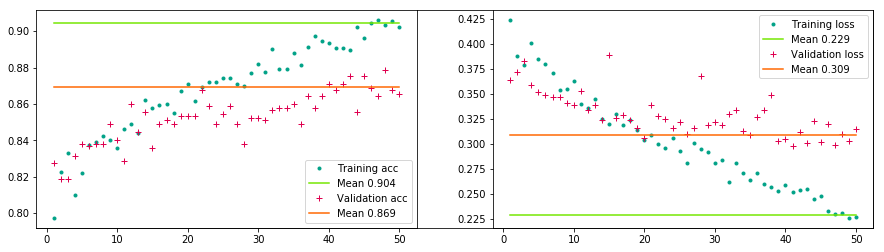

In [18]:
plot_history(hist)